In [3]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow 

### 1. Load in the Data:

In [4]:
# Load historical data from file:
df = pd.read_csv('eth_historical_4hrs.csv')

# Convert timezones and reformat:
df['time_period_start'] = pd.to_datetime(df['time_period_start']).dt.tz_convert('US/Central').dt.strftime('%m-%d-%Y %H:%M')
# Reset Index
df.set_index('time_period_start', inplace=True)

# Pull just the value fields:
df = df[['price_close', 'price_open', 'price_high', 'price_low']]

# Load just ~2018 onwards:
# df = df[2500:]

df.head()

,price_close,price_open,price_high,price_low
time_period_start,,,,
10-17-2016 07:00,11.8895,11.87000,11.90000,11.85972
10-17-2016 11:00,12.0000,11.89000,12.00000,11.89000
10-17-2016 15:00,12.0300,12.00000,12.03000,11.93356
10-17-2016 19:00,12.2000,12.02591,12.20000,12.00000
10-17-2016 23:00,12.4310,12.20000,12.54799,12.20000


### 2. Engineering Targets:

In [5]:
# Constants:
n_inputs = 6

# Calculate the pct change `n_inputs` away:
df['6prd_pctchange'] = df[['price_close']].pct_change(n_inputs)

In [6]:
def entry_flag(df, lookforward_num):
    
    '''If there will be over a 5% gain in the next 6 periods, flag as a 1. Else 0.'''
    
    entry_flags = []
    for i in range(len(df) - lookforward_num):
        if df.iloc[i+lookforward_num]['6prd_pctchange'] >= 0.05:
            entry_flags.append(1)
        else:
            entry_flags.append(0)
    # Add in buffer None's
    for i in range(lookforward_num):
        entry_flags.append(None)
    return entry_flags

In [7]:
df['entry_flag'] = entry_flag(df, n_inputs)
df['entry_flag'].value_counts()

0.0    7201
1.0    1206
Name: entry_flag, dtype: int64

In [8]:
# pd.options.display.max_rows = 999
# df[1000:1100]

### 3. Create Sequences

In [14]:
def create_sequence(df, n_input):
    data = np.array(df)
      
    X = list()
    start = 0
    for _ in range(len(data)):
        # define the end of the input sequence
        end = start + n_input
        # ensure we have enough data for this instance 
        if end <= len(data) - n_input:
            X.append(data[start:end, :])
        # move along one time step
        start += 1
    return np.array(X)

def create_targets(df, n_input):
    return np.array(df['entry_flag'][(n_input-1):-n_input].values).reshape(-1,1)
    

In [15]:
seq_len = 30
df_features = df.drop(columns=['6prd_pctchange', 'entry_flag'])
df_features = df_features[100:-100]
X = create_sequence(df_features, seq_len)
y = create_targets(df[100:-100], seq_len)

In [17]:
len(X)==len(y)

True

### 4. Normalize and Train-Test Split

In [18]:
def normalized_df(X):
    scaler = MinMaxScaler()
    # transform data
    return np.array([scaler.fit_transform(x) for x in X])

def trainTest_split(X, training_size=0.8):
    return X[:int(training_size*len(X))], X[int(training_size*len(X)):]

In [20]:
X_norm = normalized_df(X)
X_train, X_test = trainTest_split(X_norm)
y_train, y_test = trainTest_split(y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6523, 30, 4) (6523, 1)
(1631, 30, 4) (1631, 1)


### Build and Train Baseline Model:

In [21]:
# Constants:
loss = 'binary_crossentropy'
optimizer = 'adam'
epochs = 12

# Complie model:
model = Sequential()
model.add(LSTM(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
results = model.fit(X_train, y_train, epochs=epochs, verbose=1, validation_data=(X_test, y_test), shuffle=False)
model.summary() 

plt.figure(figsize=(20,4))
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.show()

Epoch 1/12
204/204 [==============================] - 2s 12ms/step - loss: 0.4831 - accuracy: 0.8442 - val_loss: 0.3797 - val_accuracy: 0.8878
Epoch 2/12
204/204 [==============================] - 2s 11ms/step - loss: 0.4415 - accuracy: 0.8464 - val_loss: 0.3622 - val_accuracy: 0.8878
Epoch 3/12
204/204 [==============================] - 2s 11ms/step - loss: 0.4368 - accuracy: 0.8464 - val_loss: 0.3549 - val_accuracy: 0.8878
Epoch 4/12
204/204 [==============================] - 2s 11ms/step - loss: 0.4329 - accuracy: 0.8464 - val_loss: 0.3519 - val_accuracy: 0.8878
Epoch 5/12
  1/204 [..............................] - ETA: 0s - loss: 0.1008 - accuracy: 1.0000

KeyboardInterrupt: 

In [75]:
predictions = model.predict(X_test)
predictions_round = [1 if x > 0.5 else 0 for x in predictions]
pd.Series(predictions_round).value_counts()

0    1631
dtype: int64

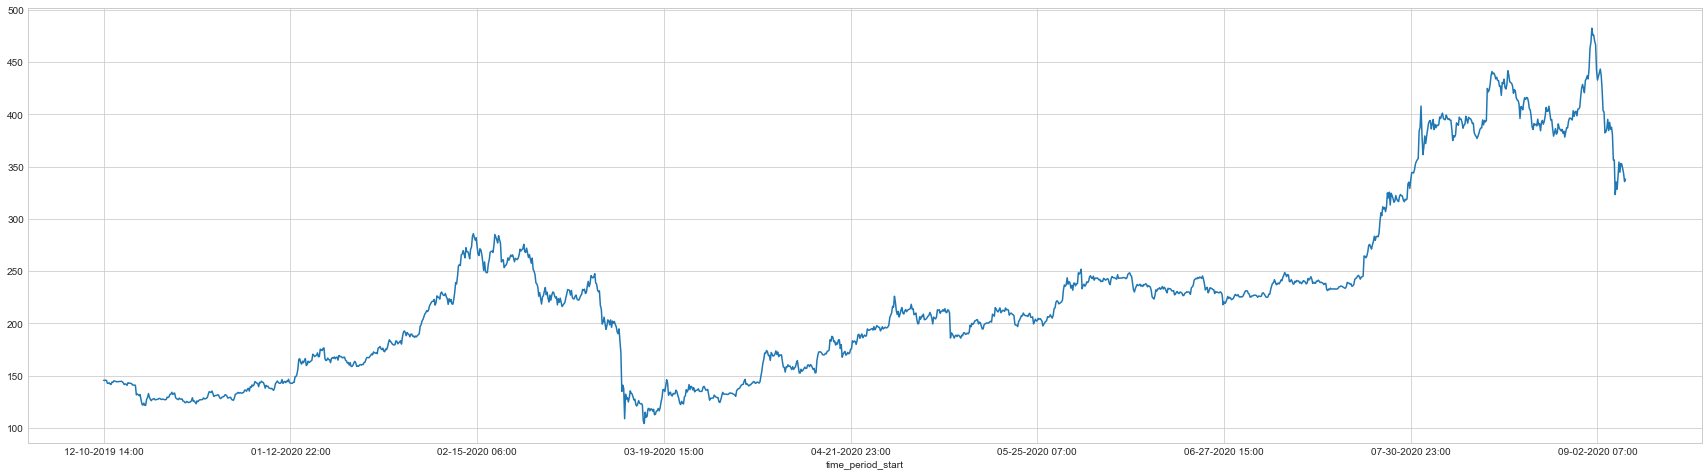

In [79]:
df_plot = df[-len(X_test):]
df_plot['predictions']= predictions_round

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(30,8))

df_plot['price_close'].plot()
# df_plot['ma_8'].plot()
# df_plot['ma_13'].plot()
# df_plot['ma_21'].plot()
# df_plot['ma_55'].plot()

for i in range(len(df_plot)):
    if df_plot.iloc[i, 3] == 1:
        plt.annotate('>', (i, df_plot.iloc[i]['price_close']), xytext=(-10, 0), textcoords='offset points', fontsize=14, fontweight='bold')

___

In [166]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train_balanced.reshape(2004, 30), y_train_balanced)

RandomForestClassifier(random_state=0)

In [174]:
X_train_balanced.reshape(2004, 30)[0]

array([1.        , 0.85760101, 0.61875896, 0.70126825, 0.84188148,
       0.5919483 , 0.81958988, 0.5922277 , 0.56764013, 0.55603878,
       0.61656017, 0.28823587, 0.26612649, 0.        , 0.13843874,
       0.02129546, 0.12314439, 0.23964382, 0.34714157, 0.21470395,
       0.28823587, 0.33403387, 0.15410967, 0.29269419, 0.28240482,
       0.14284847, 0.05973177, 0.04527564, 0.09815593, 0.0519206 ])

In [168]:
y_pred = clf.predict(X_test.reshape(len(X_test), 30))

In [177]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.56      0.69      1448
         1.0       0.12      0.47      0.19       183

    accuracy                           0.55      1631
   macro avg       0.51      0.52      0.44      1631
weighted avg       0.81      0.55      0.64      1631



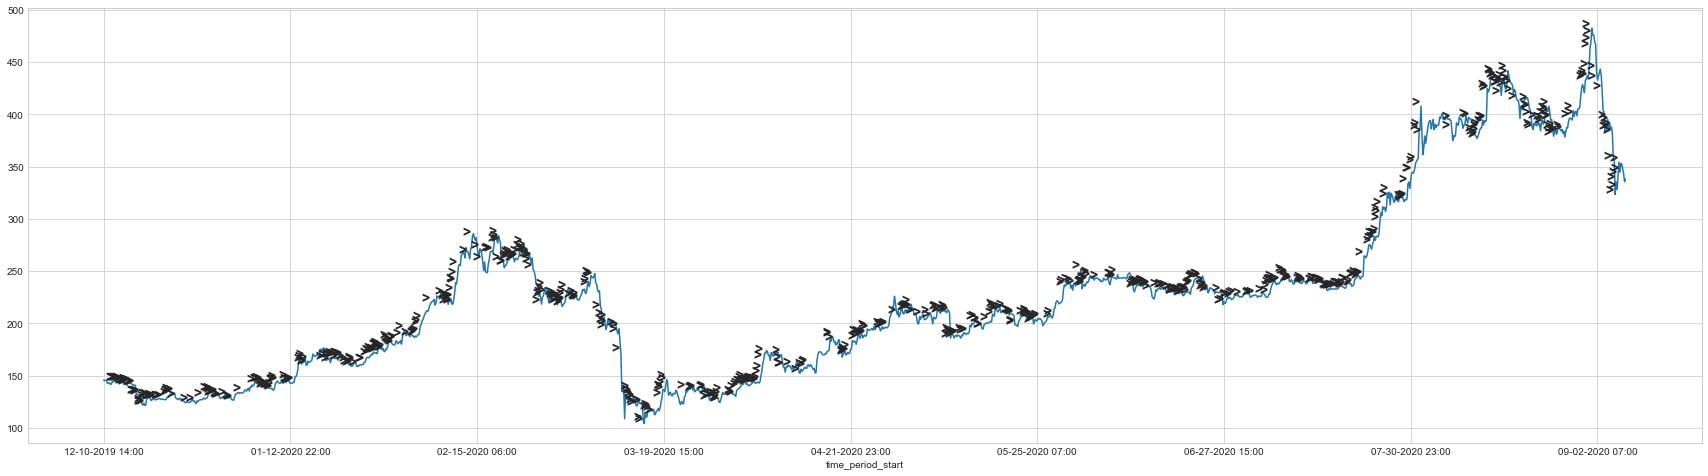

In [170]:
df_plot = df[-len(X_test):]
df_plot['predictions']= predictions_round

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(30,8))

df_plot['price_close'].plot()

for i in range(len(df_plot)):
    if y_pred[i] == 1:
        plt.annotate('>', (i, df_plot.iloc[i]['price_close']), xytext=(-10, 0), textcoords='offset points', fontsize=14, fontweight='bold')

___

In [124]:
y_train[np.where(y_train == 1)[0]]

array([1., 1., 1., ..., 1., 1., 1.])

In [127]:
X_train[np.where(y_train == 1)[0]].shape

(1002, 30, 1)

In [131]:
np.where(y_train == 0)[0][:1002]

1002

In [134]:
X_train[np.where(y_train == 1)[0]].shape

(1002, 30, 1)

In [136]:
X_train[np.where(y_train == 0)[0][:1002]].shape

(1002, 30, 1)

In [178]:
X_train_balanced = np.concatenate((X_train[np.where(y_train == 1)[0]], X_train[np.where(y_train == 0)[0][:2000]]))
y_train_balanced = np.concatenate((y_train[np.where(y_train == 1)[0]], y_train[np.where(y_train == 0)[0][:2000]]))

Epoch 1/12
94/94 [==============================] - 1s 15ms/step - loss: 1.3297 - accuracy: 0.6719 - val_loss: 0.4570 - val_accuracy: 0.8878
Epoch 2/12
94/94 [==============================] - 1s 12ms/step - loss: 0.9231 - accuracy: 0.5150 - val_loss: 0.5583 - val_accuracy: 0.8878
Epoch 3/12
94/94 [==============================] - 1s 12ms/step - loss: 0.6746 - accuracy: 0.6652 - val_loss: 0.5513 - val_accuracy: 0.8878
Epoch 4/12
94/94 [==============================] - 1s 12ms/step - loss: 0.6641 - accuracy: 0.6662 - val_loss: 0.5294 - val_accuracy: 0.8878
Epoch 5/12
94/94 [==============================] - 1s 12ms/step - loss: 0.6630 - accuracy: 0.6662 - val_loss: 0.5146 - val_accuracy: 0.8878
Epoch 6/12
94/94 [==============================] - 1s 12ms/step - loss: 0.6636 - accuracy: 0.6662 - val_loss: 0.5034 - val_accuracy: 0.8878
Epoch 7/12
94/94 [==============================] - 1s 12ms/step - loss: 0.6627 - accuracy: 0.6662 - val_loss: 0.4939 - val_accuracy: 0.8878
Epoch 8/12
94

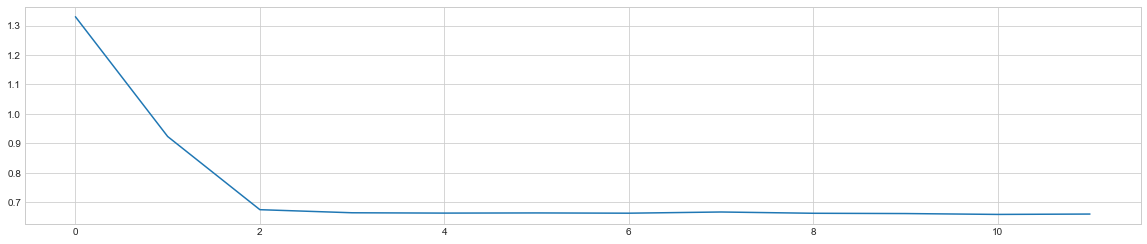

In [189]:
# Complie model:
model = Sequential()
model.add(LSTM(100, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
results = model.fit(X_train_balanced, y_train_balanced, epochs=epochs, validation_data=(X_test, y_test), verbose=1, shuffle=False)
model.summary() 

plt.figure(figsize=(20,4))
plt.plot(results.history['loss'])
plt.show()

In [186]:
predictionsn = model.predict(X_test)
predictions_round = [1 if x > 0.5 else 0 for x in predictions]
pd.Series(predictions_round).value_counts()

0    1631
dtype: int64

___

In [193]:
train, test = tensorflow.keras.datasets.imdb.load_data()

In [207]:
train[0].reshape(len(train[0]), len(train[0][0]), 1)

ValueError: cannot reshape array of size 25000 into shape (25000,218,1)

In [194]:
# Complie model:
model = Sequential()
model.add(LSTM(100, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
results = model.fit(train[0], train[1], epochs=epochs, validation_data=(test[0],test[1]), verbose=1, shuffle=False)
model.summary() 

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).